In [27]:
%matplotlib inline


Group analysis of resting-state fMRI with ICA: CanICA
=====================================================

An example applying CanICA to resting-state data. This example applies it
to 30 subjects of the ADHD200 datasets. Then it plots a map with all the
components together and an axial cut for each of the components separately.

CanICA is an ICA method for group-level analysis of fMRI data. Compared
to other strategies, it brings a well-controlled group model, as well as a
thresholding algorithm controlling for specificity and sensitivity with
an explicit model of the signal. The reference papers are:

    * G. Varoquaux et al. "A group model for stable multi-subject ICA on
      fMRI datasets", NeuroImage Vol 51 (2010), p. 288-299

    * G. Varoquaux et al. "ICA-based sparse features recovery from fMRI
      datasets", IEEE ISBI 2010, p. 1177

Pre-prints for both papers are available on hal
(http://hal.archives-ouvertes.fr)

<div class="alert alert-info"><h4>Note</h4><p>The use of the attribute `components_img_` from decomposition
    estimators is implemented from version 0.4.1.
    For older versions, unmask the deprecated attribute `components_`
    to get the components image using attribute `masker_` embedded in
    estimator.
    See the `section Inverse transform: unmasking data <unmasking_step>`.</p></div>



First we load the ADHD200 data
-------------------------------



In [28]:
import numpy as np
data=np.load('/home/share/TmpData/Qinglin/HCP_Group/MOTOR100_0.2.npy')


Here we apply CanICA on the data
---------------------------------



In [29]:
import os
cache='/home/share/TmpData/Qinglin/nilearn_cache'
if not os.path.exists(cache):
    os.makedirs(cache)

from nilearn.datasets import load_mni152_brain_mask
mask_img = load_mni152_brain_mask()
from nilearn.decomposition import CanICA
canica = CanICA(n_components=30, mask=mask_img, smoothing_fwhm=6.,
            memory=cache, memory_level=2,
            threshold=3., verbose=10, random_state=0,n_jobs=8)
canica.fit(data)
# Retrieve the independent components in brain space. Directly
# accesible through attribute `components_img_`. Note that this
# attribute is implemented from version 0.4.1. For older versions,
# see note section above for details.

# components_img is a Nifti Image object, and can be saved to a file with
# the following line:
#components_img.to_filename('canica_resting_state.nii.gz')

________________________________________________________________________________
[Memory] Calling sklearn.utils.extmath.randomized_svd...
randomized_svd(array([[-0.000749, ...,  0.001115],
       ...,
       [ 0.00085 , ...,  0.001097]], dtype=float32), n_iter=3, random_state=0, transpose=True, n_components=30)


/home/uga_qinglin/Documents/nilearn-deep/nilearn/decomposition/multi_pca.py:171: UserWarning: Persisting input arguments took 7.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  random_state=self.random_state, n_iter=3)


__________________________________________________randomized_svd - 36.7s, 0.6min


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   51.8s remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of  10 | elapsed:   59.8s remaining:   59.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:  1.3min remaining:   32.9s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.6min finished


CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None,
    mask=<nibabel.nifti1.Nifti1Image object at 0x7f5ebbff4110>,
    mask_args=None, mask_strategy='epi',
    memory=Memory(location=/home/share/TmpData/Qinglin/nilearn_cache/joblib),
    memory_level=2, n_components=30, n_init=10, n_jobs=8, random_state=0,
    smoothing_fwhm=6.0, standardize=True, t_r=None, target_affine=None,
    target_shape=None, threshold=3.0, verbose=10)

In [30]:
components_img = canica.components_

from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_img, standardize=True)
masker.fit()

components_img = masker.inverse_transform(components_img)

mask_imgTo visualize we plot the outline of all components on one figure
-----------------------------------------------------------------



/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


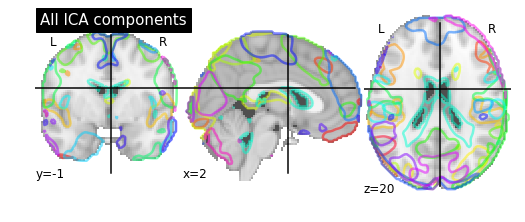

In [31]:
from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components')

Finally, we plot the map for each ICA component separately
-----------------------------------------------------------



/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


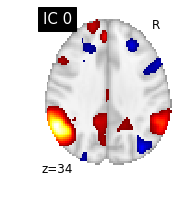

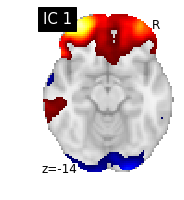

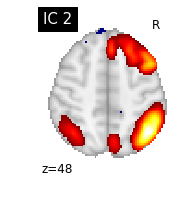

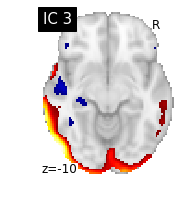

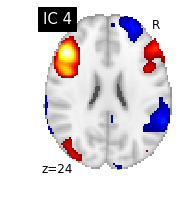

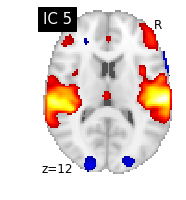

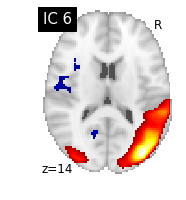

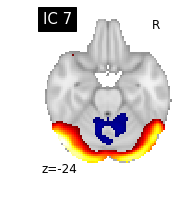

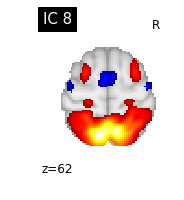

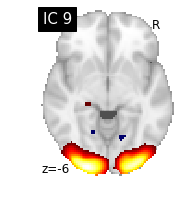

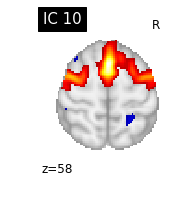

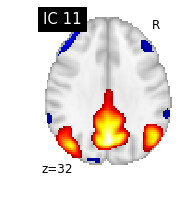

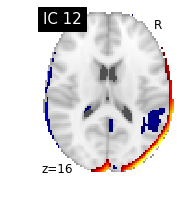

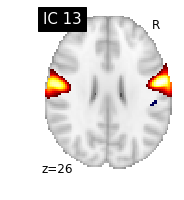

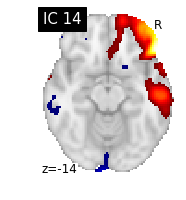

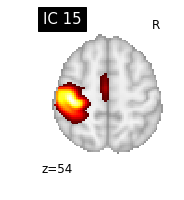

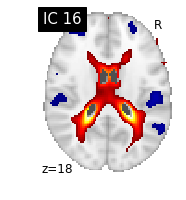

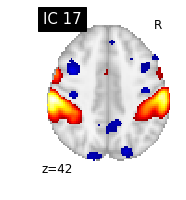

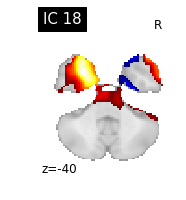

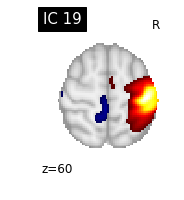

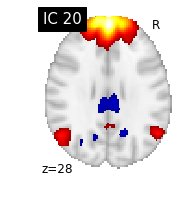

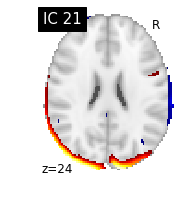

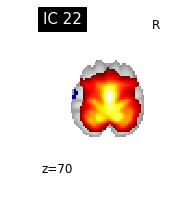

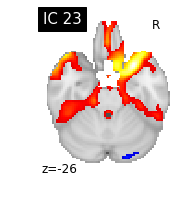

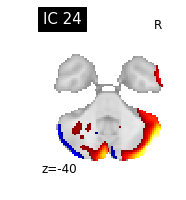

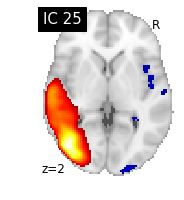

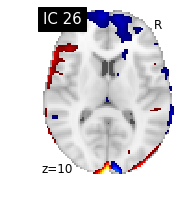

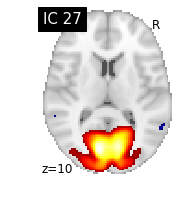

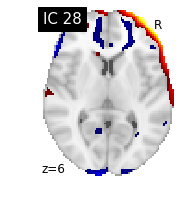

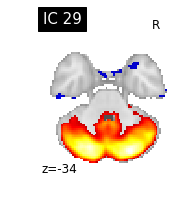

In [32]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)

show()

In [33]:
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

In [34]:
from nilearn.connectome import ConnectivityMeasure

correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(func_filenames, confounds):
    # call transform from RegionExtractor object to extract timeseries signals
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    # call fit_transform from ConnectivityMeasure object
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    # saving each subject correlation to correlations
    correlations.append(correlation)

# Mean of all correlations
import numpy as np
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted,
                                                          n_regions_extracted)

NameError: name 'func_filenames' is not defined

In [ ]:
# ----------------------------

title = 'Correlation between %d regions' % n_regions_extracted

# First plot the matrix
display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1,
                               colorbar=True, title=title)

# Then find the center of the regions and plot a connectome
regions_img = regions_extracted_img
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='90%', title=title)